<a href="https://colab.research.google.com/github/cihankaradogan/Twitter-Personality-Prediction/blob/main/training_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Information

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.56GB
Used: 626.87MB
Percentage: 3.7%


# GPU Information

In [ ]:
! nvidia-smi

Sun Feb 14 16:49:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers==3.5.1
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 1.3MB 8.6MB/s 
     |████████████████████████████████| 2.9MB 26.9MB/s 
     |████████████████████████████████| 890kB 36.0MB/s 
     |████████████████████████████████| 1.1MB 70.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=80f764e7c73665b28a3a38df08d13c4d9fb77e986aeb4b796046e3acf30edd61
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


In [ ]:
aggre = pd.read_json("/content/drive/MyDrive/bigfive-tweets/aggre.json")

In [ ]:
aggre

,id,sentence,value
0,4589,geber amk doğurduğı,aggre_neg
1,6472,bizi hâlâ cidiye alıyor olmaları güzel bundan ...,aggre_neg
2,11713,gidelim bu şehirden,aggre_pos
3,21815,insan insana elbete yeterdi,aggre_pos
4,25087,ben o yâri özlüyorum,aggre_pos
...,...,...,...
28595,11670,araliktan öncede sonrada trabzonspor için en i...,aggre_neg
28596,24,çaycı hüseyinin teyfik sikrete ölüm tehdidinde...,aggre_neg
28597,21928,bu ülkede sizden olmayan herkesi pk li ve fetö...,aggre_pos
28598,178,basit şeylerle uğraşmayı özledim,aggre_neg


In [ ]:
aggre = aggre.drop('id', axis=1)

In [ ]:
from sklearn.utils import shuffle
aggre = shuffle(aggre)

In [ ]:
aggre

,sentence,value
26763,bu sate gelen tatlı krizi sinir krizinden kötü,aggre_pos
24492,aklıma birden numaralı adam tiyatrosunda birde...,aggre_pos
10129,adı değiştik inşalah banlamaz hesap,aggre_neg
7085,önümüzdeki günlerde hasta sayısının daha da ar...,aggre_neg
15686,ilkay tarık gokay akşama planınız ne amk fm at...,aggre_neg
...,...,...
24129,uyuyamıyorum,aggre_pos
21056,babacım bu fener madem bu kadar can çekişecekt...,aggre_neg
25329,bir sosyal hizmetçi arkadaş yok mu sayfamda,aggre_pos
14251,günlük istatistiğim giden takipçi via,aggre_neg


In [ ]:
aggre.groupby('value').size()

value
aggre_neg    14300
aggre_pos    14300
dtype: int64

In [ ]:
aggre['encoded_categories'] = LabelEncoder().fit_transform(aggre['value'])

In [ ]:
aggre

,sentence,value,encoded_categories
26763,bu sate gelen tatlı krizi sinir krizinden kötü,aggre_pos,1
24492,aklıma birden numaralı adam tiyatrosunda birde...,aggre_pos,1
10129,adı değiştik inşalah banlamaz hesap,aggre_neg,0
7085,önümüzdeki günlerde hasta sayısının daha da ar...,aggre_neg,0
15686,ilkay tarık gokay akşama planınız ne amk fm at...,aggre_neg,0
...,...,...,...
24129,uyuyamıyorum,aggre_pos,1
21056,babacım bu fener madem bu kadar can çekişecekt...,aggre_neg,0
25329,bir sosyal hizmetçi arkadaş yok mu sayfamda,aggre_pos,1
14251,günlük istatistiğim giden takipçi via,aggre_neg,0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)

In [ ]:
sentences = aggre.sentence.values

In [ ]:
max_len = 250

In [ ]:
training = aggre.groupby('value').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([aggre,training]).drop_duplicates(keep=False)

In [ ]:
print("Training: ", len(training))
print("Test: ", len(test))

Training:  22880
Test:  5536


In [ ]:
training_texts = training.sentence.values
training_labels = training.encoded_categories.values

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  temuz gecesi sawaşan yiğitler
Token IDs: tensor([    2,  2343,  2050,  8831, 47072, 20116, 92762, 11106,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

In [ ]:
number_of_categories = len(aggre['encoded_categories'].unique())

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
epochs = 9

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 9 ========
Batch    10  of    715.    Elapsed: 0:00:08.
Batch    20  of    715.    Elapsed: 0:00:16.
Batch    30  of    715.    Elapsed: 0:00:23.
Batch    40  of    715.    Elapsed: 0:00:31.
Batch    50  of    715.    Elapsed: 0:00:39.
Batch    60  of    715.    Elapsed: 0:00:47.
Batch    70  of    715.    Elapsed: 0:00:54.
Batch    80  of    715.    Elapsed: 0:01:02.
Batch    90  of    715.    Elapsed: 0:01:10.
Batch   100  of    715.    Elapsed: 0:01:17.
Batch   110  of    715.    Elapsed: 0:01:25.
Batch   120  of    715.    Elapsed: 0:01:33.
Batch   130  of    715.    Elapsed: 0:01:41.
Batch   140  of    715.    Elapsed: 0:01:48.
Batch   150  of    715.    Elapsed: 0:01:56.
Batch   160  of    715.    Elapsed: 0:02:04.
Batch   170  of    715.    Elapsed: 0:02:12.
Batch   180  of    715.    Elapsed: 0:02:19.
Batch   190  of    715.    Elapsed: 0:02:27.
Batch   200  of    715.    Elapsed: 0:02:35.
Batch   210  of    715.    Elapsed: 0:02:43.
Batch   220  of    715.  

In [ ]:
torch.save(model, '/content/drive/MyDrive/modeller/Agreeableness_28k_9epoch.pt')

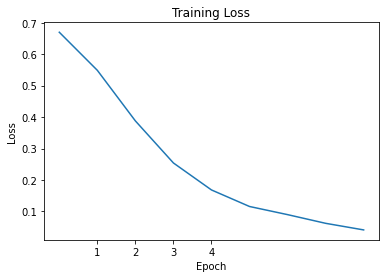

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [ ]:
test_texts = test.sentence.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [ ]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')
accuracy = accuracy_score(test_labels, prediction_scores)

In [ ]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.6829667148138485
Recall:  0.682971259450144
Precision:  0.6829996583818054


In [ ]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [ ]:
aggre

,sentence,value,encoded_categories
26763,bu sate gelen tatlı krizi sinir krizinden kötü,aggre_pos,1
24492,aklıma birden numaralı adam tiyatrosunda birde...,aggre_pos,1
10129,adı değiştik inşalah banlamaz hesap,aggre_neg,0
7085,önümüzdeki günlerde hasta sayısının daha da ar...,aggre_neg,0
15686,ilkay tarık gokay akşama planınız ne amk fm at...,aggre_neg,0
...,...,...,...
24129,uyuyamıyorum,aggre_pos,1
21056,babacım bu fener madem bu kadar can çekişecekt...,aggre_neg,0
25329,bir sosyal hizmetçi arkadaş yok mu sayfamda,aggre_pos,1
14251,günlük istatistiğim giden takipçi via,aggre_neg,0


In [ ]:
report = report.rename(columns={'0':'negative',
                          '1':'positive',})

In [ ]:
test

,sentence,value,encoded_categories
26763,bu sate gelen tatlı krizi sinir krizinden kötü,aggre_pos,1
10129,adı değiştik inşalah banlamaz hesap,aggre_neg,0
7085,önümüzdeki günlerde hasta sayısının daha da ar...,aggre_neg,0
27437,arkadaslarim buyuyun bebek yapin ben de sevim,aggre_neg,0
5521,kulaklık takıp son ses müzik dinleyip hayatan ...,aggre_pos,1
...,...,...,...
3533,günah işlemiyorsan hiç eglenmiyorsun demektir,aggre_neg,0
3755,daha geçen ay başlayıp haftada bölüm izlemişti...,aggre_pos,1
13784,şu şekil mercedesimle bi fotom olmıcaksa ben b...,aggre_neg,0
21056,babacım bu fener madem bu kadar can çekişecekt...,aggre_neg,0


In [ ]:
report


,negative,positive,accuracy,macro avg,weighted avg
precision,0.684230,0.681770,0.682984,0.683000,0.682997
recall,0.677046,0.688897,0.682984,0.682971,0.682984
f1-score,0.680619,0.685315,0.682984,0.682967,0.682972
support,2762.000000,2774.000000,0.682984,5536.000000,5536.000000


In [ ]:
accuracy

0.6829841040462428

## **TEST**

In [ ]:
from tqdm import tqdm

In [ ]:
def karamsar_print_percentage(df):
  total_count = 0
  neg_count = 0
  for idx, row in tqdm(df.iterrows()):
    if row['tahmin'] == 0:
      neg_count += 1
    total_count += 1
  print()
  result = str(neg_count / (total_count / 100))
  slice_idx = 4
  if len(result) < 4:
    slice_idx = 2
  print(f"karamsar percentage: {result[:slice_idx]}%")

In [ ]:
def memnun_print_percentage(df):
  total_count = 0
  neg_count = 0
  for idx, row in tqdm(df.iterrows()):
    if row['tahmin'] == 1:
      neg_count += 1
    total_count += 1
  print()
  result = str(neg_count / (total_count / 100))
  slice_idx = 4
  if len(result) < 4:
    slice_idx = 2
  print(f"memnun percentage: {result[:slice_idx]}%")

In [ ]:
def percentage(df):
  karamsar_print_percentage(df)
  memnun_print_percentage(df)

In [ ]:
!pip install snscrape
!pip install emoji
!pip install zemberek_grpc
!pip install grpcio==1.35.0

     |████████████████████████████████| 133kB 4.0MB/s 
     |████████████████████████████████| 2.5MB 6.1MB/s 
ERROR: grpcio-tools 1.35.0 has requirement grpcio>=1.35.0, but you'll have grpcio 1.32.0 which is incompatible.
     |████████████████████████████████| 4.1MB 4.9MB/s 
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.35.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
cd /content/drive/MyDrive/datas

/content/drive/MyDrive/datas


In [ ]:
model = torch.load('/content/drive/MyDrive/duygudurum.pt')
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# -*- coding: utf-8 -*-

import csv
import snscrape.modules.twitter as sntwitter
from string import punctuation, digits
import itertools
import pandas as pd
import nltk
import json
import re
import emoji
import sys
import grpc

import zemberek_grpc.normalization_pb2 as z_normalization
import zemberek_grpc.normalization_pb2_grpc as z_normalization_g

channel = grpc.insecure_channel('138.197.77.125:6789')

normalization_stub = z_normalization_g.NormalizationServiceStub(channel)

def normalize(text):
    response = normalization_stub.Normalize(z_normalization.NormalizationRequest(input=text))
    if response.normalized_input:
        return response.normalized_input
    return text

def lower(text):
    text=re.sub("İ","i",text)
    text = text.lower()
    return text

#TODO: translate emojis to turkish
def replace_emoji(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def resubComma(text):
    return re.sub(","," ",text)

def vanish_punc(text):
    regex = re.compile('[%s]' % re.escape(punctuation))
    text = regex.sub(' ', text)
    return text

def replace_emoticon(word):
    check_pos = re.findall(r'(?::\)|:-\)|=\)|:D|:d|<3|\(:|:\'\)|\^\^|;\)|\(-:)', word)
    check_neg = re.findall(r'(:-\(|:\(|;\(|;-\(|=\(|:/|:\\|-_-|\):|\)-:)', word)
    if check_pos:
        #word = ":)"
        word = "SMILEYPOSITIVE"
    elif check_neg:
        #word = ":("
        word = "SMILEYNEGATIVE"
    return word

def remove_emoticon(text):
    new_text = re.sub(r'(?::\)|:-\)|=\)|:D|:d|<3|\(:|:\'\)|\^\^|;\)|\(-:)', '', text)
    new_text = re.sub(r'(:-\(|:\(|;\(|;-\(|=\(|:/|:\\|-_-|\):|\)-:)', '', new_text)
    return new_text

def remove_user_handle(text):
    return re.sub('@[^\s]+', '', text)

def remove_digits_and_extensions(text):
    return re.sub(r'[0-9][^\s]+', '', text)

def remove_digits(text):
    text = text.strip()
    vanish_digits = str.maketrans('', '', digits)
    text = text.translate(vanish_digits)
    return text

def remove_hashtag_and_word(text):
    return re.sub('#[^\s]+', '', text)

def remove_newline_char(text):
    return re.sub(' +', ' ', text.replace('\n', ' '))

def remove_extra_spaces(text):
    return re.sub(' +', ' ', text)

def dup_vanish(text):
     return (''.join(i for i, _ in itertools.groupby(text)))

def preprocess_sentence(sentence, stopwords):
    sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence)
    sentence = remove_user_handle(sentence)
    sentence = remove_hashtag_and_word(sentence)
    sentence = dup_vanish(sentence)
    sentence = remove_emoticon(sentence)
    sentence = remove_emoji(sentence)
    sentence = lower(sentence)
    sentence = resubComma(sentence)
    sentence = vanish_punc(sentence)
    sentence = remove_digits_and_extensions(sentence)
    sentence = remove_digits(sentence)
    sentence = remove_newline_char(sentence)

    sentence = remove_extra_spaces(sentence)
    # sentence = normalize(sentence)

    return sentence

# Bu fonksiyon bir username listesi ile calisiyor.
def save_tweets_with_ulist(username_list, n_tweets, criteria, stopwords, filename):
    """
    Finds the latest tweets according to a query and saves them in a csv file
    :param query: the query to look for
    :param n_tweets: number of tweets to scrape
    """
    data = list()
    index = 26002
    output_stream = sys.stdout
    for username in username_list:
      if len(username) < 2:
        continue
      tweets_gen = sntwitter.TwitterSearchScraper(f"(from:{username}) lang:tr -filter:replies").get_items()
      top_tweets = itertools.islice(tweets_gen, n_tweets)
      for tweet in top_tweets:
          # writer.writerow([tweet.id, tweet.date, tweet.username, tweet.content, tweet.url])
          pped_sentence = preprocess_sentence(tweet.content, stopwords)
          print(pped_sentence)
          data.append({"id": index, "sentence": pped_sentence, "value": criteria})
          output_stream.write('Update %s\r' % index)
          output_stream.flush()
          index += 1
    
    with open(filename, 'w', encoding='utf-8') as outfile:
      json.dump(data, outfile, ensure_ascii=False)
    print('')
    print('Done!')

# bu direk twitterda advanced search ile yaptigin aramayi query parametresine koyup ayni sonucu alabilirsin
# n_tweets => kac tweet cekmek istedigin, stopwords NLTK Turkish'ten cekiyor
# filename => kaydetmek istedigin yerin pathi dosya ismi ile birlikte ornek kullanim asagida.
def save_tweets_with_query(query, n_tweets, stopwords, filename):
    data = list()
    index = 1
    output_stream = sys.stdout
    tweets_gen = sntwitter.TwitterSearchScraper(query).get_items()
    top_tweets = itertools.islice(tweets_gen, n_tweets)
    for tweet in top_tweets:
        # writer.writerow([tweet.id, tweet.date, tweet.username, tweet.content, tweet.url])
        pped_sentence = preprocess_sentence(tweet.content, stopwords)
        data.append({"id": index, "sentence": pped_sentence, "date": str(tweet.date)})
        output_stream.write('Update %s\r' % index)
        output_stream.flush()
        index += 1
    
    with open(filename, 'w', encoding='utf-8') as outfile:
      json.dump(data, outfile, ensure_ascii=False)
    print('')
    print('Done!')

def extract_username_list(filename, index):
  username_list = list()
  with open(filename, 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=",")
    for row in csvreader:
      username_list.append(row[index])
  return username_list

WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')


# username_list = extract_username_list('kullanicilar.csv', 1)
# save_tweets_with_ulist(username_list, 2500, 'iktidar', stop_word_list, 'iktidar_tweets.json')

save_tweets_with_query("(from:@AysegulGuven06) lang:tr -filter:replies", 10000, stop_word_list, "memnun.json")


Done!


In [ ]:
tahmin = pd.read_json("/content/drive/MyDrive/datas/memnun.json").drop_duplicates(['sentence'])

In [ ]:
test_texts = tahmin.sentence.values

In [ ]:
input_ids = list()
attention_masks = list()
max_len = 250

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def predict(model, prediction_dataloader):
  print('Prediction started on test data')
  model.eval()
  predictions , true_labels = [], []

  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    # label_ids = b_labels.to('cpu').numpy()
    
    predictions.append(logits)
    # true_labels.append(label_ids)
  print('Prediction completed')
  return predictions

In [ ]:
predictions = predict(model, prediction_dataloader)

Prediction started on test data
Prediction completed


In [ ]:
def map_predictions_to_df(df, predictions):
  prediction_set = []

  for i in range(len(predictions)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    prediction_set.append(pred_labels_i)

  prediction_scores = [item for sublist in prediction_set for item in sublist]
  df['tahmin'] = prediction_scores
  return df

In [ ]:
map_predictions_to_df(tahmin, predictions)

,id,sentence,date,tahmin
0,1,oysa her şeye rağmen hayatı güzeleştiren şeyle...,2021-02-02 04:48:27+00:00,1
1,2,güzeliklere çıksın yolarınız ya da yolunuzdaki...,2021-01-28 04:23:22+00:00,1
2,3,pırasa yemiyen köpek te ne bileyim,2021-01-27 08:23:44+00:00,1
3,4,beklemek lâzım gönlü hoş tutanı gönülde yer bu...,2021-01-26 17:26:43+00:00,0
4,5,malesef oyle,2021-01-26 14:54:07+00:00,0
...,...,...,...,...
1146,1147,rabim üzüntülerimizi anlık sevinçlerimizi ömür...,2018-12-14 07:42:23+00:00,1
1147,1148,sorarlar dervişe sevgi denen duyguya ulaşan in...,2018-12-13 21:47:16+00:00,1
1148,1149,aynı adama kaldı her sahip olmaya çalıştı işte...,2018-04-29 16:15:23+00:00,0
1149,1150,haberleşme araçları çoğaldı ama insanlar ruhen...,2018-04-28 14:48:53+00:00,1


In [ ]:
percentage(tahmin)

1150it [00:00, 13702.13it/s]
1150it [00:00, 13783.21it/s]


karamsar percentage: 19.9%

memnun percentage: 80.0%


In [ ]:
tahmin.style.set_properties(subset=['sentence'], **{'width': '300px'})

,id,sentence,date,tahmin
0,1,oysa her şeye rağmen hayatı güzeleştiren şeyler de var çocuklar gibi çiçekler gibi kuşlar gibi siz degerli dostlar gibi mutlu gunler olsun,2021-02-02 04:48:27+00:00,1
1,2,güzeliklere çıksın yolarınız ya da yolunuzdaki güzelikleri gören gözleriniz olsun yaşamak,2021-01-28 04:23:22+00:00,1
2,3,pırasa yemiyen köpek te ne bileyim,2021-01-27 08:23:44+00:00,1
3,4,beklemek lâzım gönlü hoş tutanı gönülde yer bulanı başka gönülde gözü olmayanı,2021-01-26 17:26:43+00:00,0
4,5,malesef oyle,2021-01-26 14:54:07+00:00,0
5,6,ne garip değil mi hiçbir öz ve hiçbir söz hiç kimsenin yüreğine değmiyor artık bakıyoruz seviyoruz okuyoruz geçiyoruz oysa kalmalı insan herhangi bir şeyde vazgeçmediği bir değeri olmalı yüreğinin bir köşesinde,2021-01-26 14:48:49+00:00,1
6,7,aferin bana nasilda da yürümüsüm baksaniza,2021-01-25 09:51:36+00:00,0
7,8,havanın soğukluğu kalbinizi üşütmesin yüreğinizi sevgiyle örtün,2021-01-24 04:47:54+00:00,1
8,9,çok tatli burcum var benim,2021-01-23 01:55:59+00:00,0
9,10,çiçek açsın mı gönlünüz o zaman tebesüm ediniz zarifçe tüm anlamsız boş hüzünlerinize sabahatin ali,2021-01-22 18:00:53+00:00,1
